# Download and extract data

In [1]:
!wget http://konect.cc/files/download.tsv.dblp_coauthor.tar.bz2
!tar -xf download.tsv.dblp_coauthor.tar.bz2
!rm download.tsv.dblp_coauthor.tar.bz2

--2021-02-02 16:22:06--  http://konect.cc/files/download.tsv.dblp_coauthor.tar.bz2
Resolving konect.cc (konect.cc)... 138.48.20.248
Connecting to konect.cc (konect.cc)|138.48.20.248|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137231649 (131M) [application/x-bzip2]
Saving to: 'download.tsv.dblp_coauthor.tar.bz2'

100%[======================================>] 137,231,649 49.5MB/s   in 2.6s   

2021-02-02 16:22:09 (49.5 MB/s) - 'download.tsv.dblp_coauthor.tar.bz2' saved [137231649/137231649]



# Setup

In [8]:
from importlib import reload
import os

import joblib
import matplotlib.pyplot as plt
import matplotlib.ticker 
import networkx as nx
import numpy as np
import pandas as pd
import sklearn.metrics
import seaborn as sns
from tqdm.auto import tqdm

import lp
reload(lp)

temp_path = '01/temp'

cutoff = 2

adjusted_intervals = dict(t_min=pd.Timestamp('1996-01-01'), 
                          t_split=pd.Timestamp('2005-01-01'),
                          t_max=pd.Timestamp('2007-01-01'))

# Get network

In [ ]:
%%time
edgelist = lp.konect_to_pandas('01 dblp_coauthor/out.dblp_coauthor', sep='\t', 
                               datetime_with_space=True)
edgelist.to_pickle(f'{temp_path}/edgelist.pkl')

%%time
multigraph = nx.from_pandas_edgelist(edgelist, source='u', target='v',
                                     edge_attr=True, create_using=nx.MultiGraph)
nx.write_gpickle(multigraph, f'{temp_path}/multigraph.pkl')

## Figure: Event distribution with maturing and probing intervals indicated

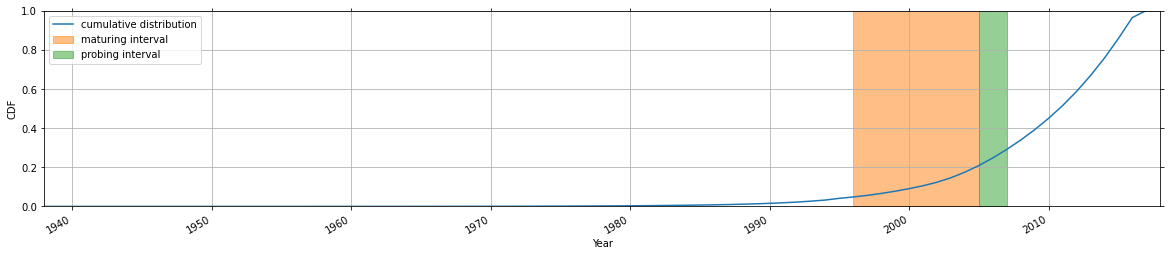

In [86]:
lp.plot_interval(joblib.load(f'{temp_path}/edgelist.pkl')['datetime'],
                 **adjusted_intervals)

# Maturing and probing

In [63]:
%%time
edgelist_mature, edgelist_probe = lp.split_in_intervals(
  edgelist=joblib.load(f'{temp_path}/edgelist.pkl'), **adjusted_intervals)

index, y = lp.get_instances(
  edgelist_mature=edgelist_mature, edgelist_probe=edgelist_probe, 
  cutoff=cutoff, verbose=True)

Determine targets:   0%|          | 0/10924683 [00:00<?, ?it/s]

CPU times: user 1min 36s, sys: 3.83 s, total: 1min 40s
Wall time: 1min 40s


In [64]:
%%time
edgelist_mature.to_pickle(f'{temp_path}/edgelist_mature.pkl')

np.save(f'{temp_path}/index', index)
np.save(f'{temp_path}/y', y)

## Metric: class imbalance

In [22]:
pd.Series(y).value_counts()

False    10884158
True        40525
dtype: int64

In [23]:
pd.Series(y).value_counts(normalize=True)

False    0.996291
True     0.003709
dtype: float64

# Network characteristics

In [30]:
%%time
for folder in ['stats', 'path_distribution']: 
  os.makedirs(f'{temp_path}/{folder}', exist_ok=True)

# Complete graph 
path_distribution, stat = lp.report(
  graph=nx.from_pandas_edgelist(
    joblib.load(f'{temp_path}/edgelist.pkl'), source='u', target='v', 
    create_using=nx.MultiGraph))
joblib.dump(stat, f'{temp_path}/stats/complete.pkl')
joblib.dump(path_distribution, f'{temp_path}/path_distribution/complete.pkl')

# Graph of maturing interval
graph_mature = nx.from_pandas_edgelist(
  joblib.load(f'{temp_path}/edgelist_mature.pkl'), source='u', target='v', 
  edge_attr=True, create_using=nx.MultiGraph)

path_distribution, stat = lp.report(graph_mature)
joblib.dump(stat, f'{temp_path}/stats/mature.pkl')
joblib.dump(path_distribution, f'{temp_path}/path_distribution/mature.pkl')

# Graph of maturing and probing interval
edgelist_mature_probe = pd.concat(
  lp.split_in_intervals(edgelist=joblib.load(f'{temp_path}/edgelist.pkl'), 
                        **adjusted_intervals)
)
graph_mature_probe = (
  nx.from_pandas_edgelist(edgelist_mature_probe, source='u', target='v', 
                          edge_attr=True, create_using=nx.MultiGraph))

path_distribution, stat = lp.report(graph_mature_probe)
joblib.dump(stat, f'{temp_path}/stats/mature_probe.pkl')
joblib.dump(path_distribution, 
            f'{temp_path}/path_distribution/mature_probe.pkl')

CPU times: user 45min 58s, sys: 3min 20s, total: 49min 19s
Wall time: 52min 45s


['01 dblp_coauthor/temp/path_distribution/mature_probe.pkl']

## Table: Statistics

In [34]:
pd.DataFrame.from_dict(
  {file.split('.')[0]: joblib.load(f'{temp_path}/stats/{file}') 
   for file in os.listdir(f'{temp_path}/stats')}, orient='index')

,nodes,nodes (GC),edges,edges (GC),edges (simplegraph),"edges (simplegraph, GC)",average number of edges between connected node pairs,density,density (GC),density (simplegraph),"density (simplegraph, GC)",assortativity,assortativity (simplegraph),diameter,average path length,average clustering coefficient
complete,1824701,1653767,29487744,29078532,8344615,8159739,0.282986,0.000018,0.000021,0.000005,0.000006,0.153840,0.114186,22,5.771862,0.632629
mature_probe,578329,484620,6081670,5837692,1825758,1718372,0.300207,0.000036,0.000050,0.000011,0.000015,0.213335,0.283691,21,6.891494,0.622884
mature,425283,342902,3937798,3717600,1223012,1126693,0.310583,0.000044,0.000063,0.000014,0.000019,0.248053,0.345722,22,7.299453,0.617229


## Figure: Path distributions

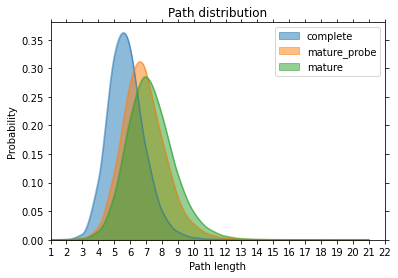

In [46]:
df = pd.DataFrame(
  {file.split('.')[0]: (
    pd.Series(joblib.load(f'{temp_path}/path_distribution/{file}')[:,1])
    .transform(lambda x: x/x.sum()))
   for file in os.listdir(f'{temp_path}/path_distribution')})
with plt.rc_context({'xtick.top': True, 'ytick.right': True}):
  ax = (df
   .reindex(np.arange(0, df.index.max(), .1))
   .interpolate('akima', limit_area='inside')
   .dropna(how='all')
  ).plot(kind='area', xlim=(1), ylim=(0), stacked=False, alpha=.5, 
         title='Path distribution', xlabel='Path length', ylabel='Probability')
  ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())

## Figure: Time strategies

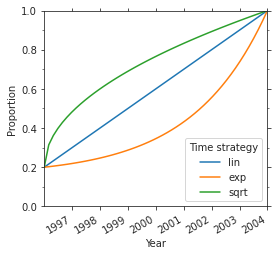

In [51]:
edgelist_mature, _ = lp.split_in_intervals(
  edgelist=joblib.load(f'{temp_path}/edgelist.pkl'), **adjusted_intervals)
lp.plot_time_strategies(edgelist_mature['datetime'])

## Figure: Time output distribution

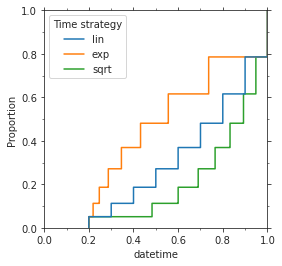

In [48]:
import seaborn as sns
edgelist_mature, _ = lp.split_in_intervals(
  edgelist=joblib.load(f'{temp_path}/edgelist.pkl'), **adjusted_intervals)
sns.set_style('ticks')
data = pd.concat(
  {time_str: time_func(edgelist_mature['datetime']) 
   for time_str, time_func in lp.TIME_STRATEGIES.items()}, 
  names=['Time strategy', 'index']
).reset_index('Time strategy').reset_index(drop=True)
with plt.rc_context({'xtick.top': True, 'ytick.right': True, 
                     'figure.figsize': (4,4)}):
  ax = sns.ecdfplot(data=data, x='datetime', hue='Time strategy')
  ax.set_xlim((0,1))
  ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.1))
  ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.1))

# Sample

In [55]:
%%time
index_sampled, index_y = lp.balanced_sample(
  index=np.load(f'{temp_path}/index.npy'), 
  y=np.load(f'{temp_path}/y.npy'), 
  size=10000)

np.save(f'{temp_path}/index_sampled', index_sampled)
np.save(f'{temp_path}/y_sampled', index_y)

CPU times: user 224 ms, sys: 59.1 ms, total: 283 ms
Wall time: 284 ms


# Learn

## Adamic Adar

### Time agnostic

In [2]:
%%time
adamic_adar_time_agnostic = lp.adamic_adar_time_agnostic(
  edgelist=joblib.load(f'{temp_path}/edgelist_mature.pkl'),
  samples=np.load(f'{temp_path}/index_sampled.npy'))
joblib.dump([adamic_adar_time_agnostic], 
            f'{temp_path}/features/adamic-adar-time-agnostic.pkl')

CPU times: user 6.86 s, sys: 355 ms, total: 7.22 s
Wall time: 7.28 s


['01/temp/features/adamic-adar-time-agnostic.pkl']

### Time aware

In [3]:
adamic_adar_time_aware = lp.adamic_adar_time_aware(
  edgelist=joblib.load(f'{temp_path}/edgelist_mature.pkl'),
  samples=np.load(f'{temp_path}/index_sampled.npy'),
  verbose=True
)

joblib.dump(adamic_adar_time_aware, 
            f'{temp_path}/features/adamic-adar-time-aware.pkl')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

['01/temp/features/adamic-adar-time-aware.pkl']

### Some plots

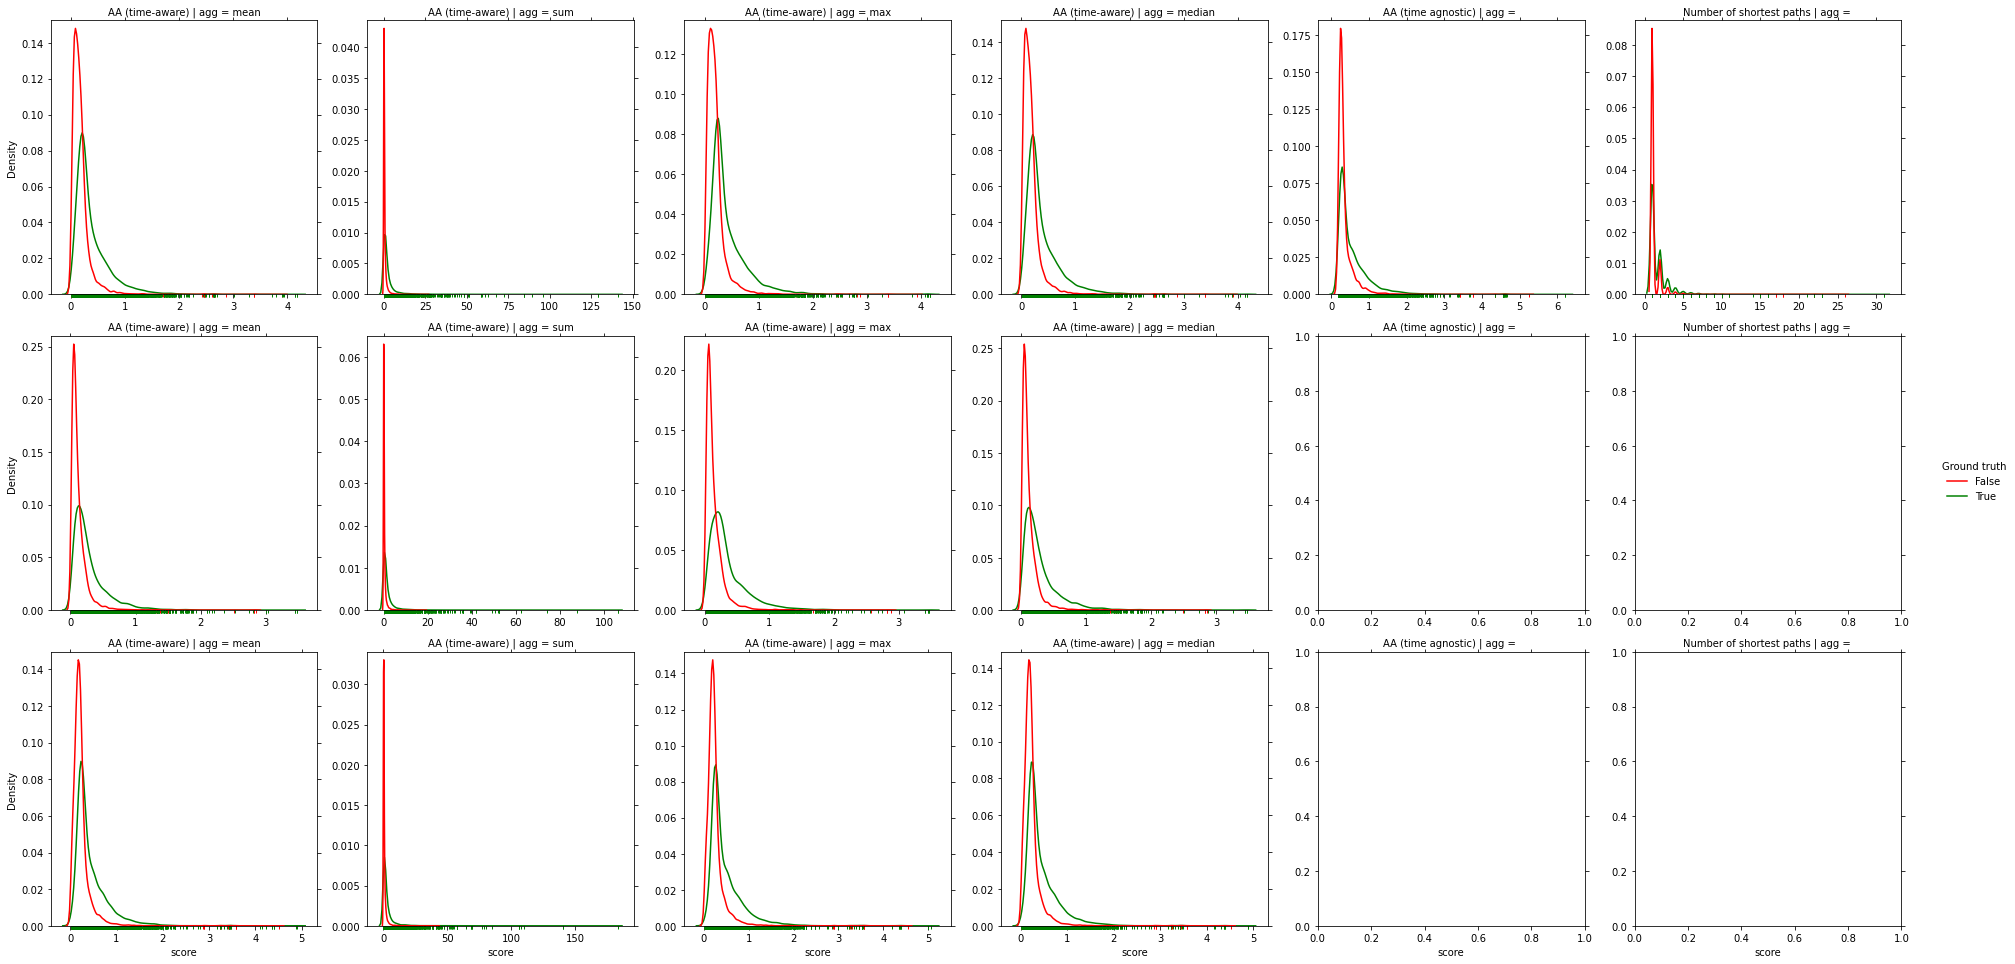

In [110]:
with plt.rc_context({'xtick.top': True, 'ytick.right': True}):
  g = sns.displot(
    (pd.concat(
      [pd.DataFrame({'Ground truth': np.load(f'{temp_path}/samples_y.npy'), 
                     **experiment}) for experiment in experiments],
      ignore_index=True)
     .fillna({'Time strategy': 'lin'})
     .assign(Feature = lambda x: (
       x['Feature'] + ' | agg = ' + x['Aggregation strategy'].fillna('')))), 
    x='score', hue='Ground truth', col='Feature', row='Time strategy', 
    kind='kde', palette=['red', 'green'], height=4.5, rug=True,
    rug_kws=dict(height=-.01, clip_on=False), 
    facet_kws=dict(sharex=False, sharey=False, despine=False))
  g.set_titles('{col_name}')

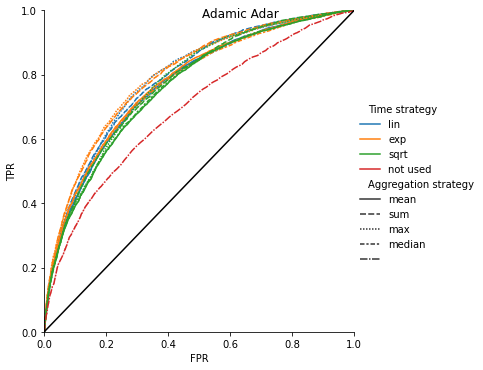

In [71]:
data = pd.DataFrame([
  dict(FPR=fpr, TPR=tpr, **experiment)
  for experiment in experiments
  for fpr, tpr, _ in zip(*roc_curve(samples_y, experiment['score']))]
).drop(columns='score')

g = sns.relplot(
  data=data.fillna({'Time strategy': 'not used', 'Aggregation strategy': ''}), 
  x='FPR', y='TPR', hue='Time strategy', style='Aggregation strategy', aspect=1, 
  kind='line')
plt.axline((0,0), (1,1), c='black')
g.fig.suptitle('Adamic Adar')
g.set(xlim=(0,1), ylim=(0,1))

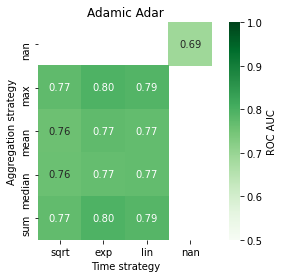

In [87]:
sns.heatmap(
  (pd.DataFrame(
    [{'ROC AUC': roc_auc_score(np.load(f'{temp_path}/samples_y.npy'), 
                               experiment['score']), **experiment} 
     for experiment in experiments])
   .fillna(dict(time='not used', agg=''))
   .pivot(index='Aggregation strategy', columns='Time strategy')
  )['ROC AUC'].sort_values('median', axis='columns'),
  vmin=.5, vmax=1, annot=True, fmt='.2f', square=True, cmap='Greens',
  cbar_kws=dict(label='ROC AUC')
)
plt.title('Adamic Adar');

## Number of shortest path
Mind that only distance-2 node pairs are used at the moment.

In [241]:
# Slow method, but providing also shortest paths at greater distance:
# [len(list(nx.all_shortest_paths(multigraph_mature, *sample))) for sample in tqdm(np.load('temp/samples.npy'))]

def single_source_number_paths_length_2(graph: nx.Graph, source):
  result = Counter()
  for nb in graph[source]: 
    for nnb in graph[nb]: 
      result[nnb] += 1
  return result

multigraph_mature = nx.read_gpickle(f'{temp_path}/multigraph-mature.pkl')

paths__of_length_2_from_node_u = {
  node: single_source_number_paths_length_2(multigraph_mature, node) 
  for node in np.load(f'{temp_path}/samples.npy')[:,0]}

joblib.dump(
  {Experiment('Number of shortest paths'): 
   np.array([paths__of_length_2_from_node_u[u][v] 
             for u, v in tqdm(np.load(f'{temp_path}/samples.npy'))])}, 
  f'{temp_path}/features/number-shortest-paths-time-unaware.pkl')

  0%|          | 0/20000 [00:00<?, ?it/s]

['01 dblp_coauthor/temp/features/number-shortest-paths-time-unaware.pkl']

## Node attributes

In [95]:
edgelist = joblib.load(f'{temp_path}/edgelist_mature.pkl')
samples=np.load(f'{temp_path}/index_sampled.npy')
verbose=True

def get_node_attributes(edgelist, samples, aggregation_strategy, time_strategy, **kwargs):
  edgelist['datetime_transformed'] = time_strategy(edgelist['datetime'])
  graph = nx.from_pandas_edgelist(
    edgelist, source='u', target='v', edge_attr=True, 
    create_using=nx.MultiGraph)
  
  result = list()
  for u, v in tqdm(samples):
    activity_u = aggregation_strategy(
      [edge_attributes['datetime_transformed'] 
       for nb in graph[u]
       for edge_attributes in graph.get_edge_data(u, nb).values()])
    activity_v = aggregation_strategy(
      [edge_attributes['datetime_transformed'] 
       for nb in graph[v]
       for edge_attributes in graph.get_edge_data(v, nb).values()])
    result.append(activity_u +activity_v)
  return result #!

In [96]:
t = [
    lp.Experiment(
      feature='N (time_aware)', time_strategy=time_str, aggregation_strategy=agg_str,
      scores=get_node_attributes(
        edgelist, samples, aggregation_strategy=agg_func, time_strategy=time_func, 
        verbose=verbose, position=2, leave=False))
    for time_str, time_func in tqdm(lp.TIME_STRATEGIES.items(), position=0, 
                                    disable=not verbose)
    for agg_str, agg_func in tqdm(lp.AGGREGATION_STRATEGIES.items(), position=1, 
                                  leave=False, disable=not verbose)]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [90]:
joblib.dump(t, f'{temp_path}/features/N.pkl')

['01/temp/features/N.pkl']

# Results

In [97]:
path = f'{temp_path}/features/'
experiments = list()
for file in os.listdir(path): 
  if file.endswith('.pkl'):
    experiments.extend(joblib.load(path + file))

## Figure: Score distribution

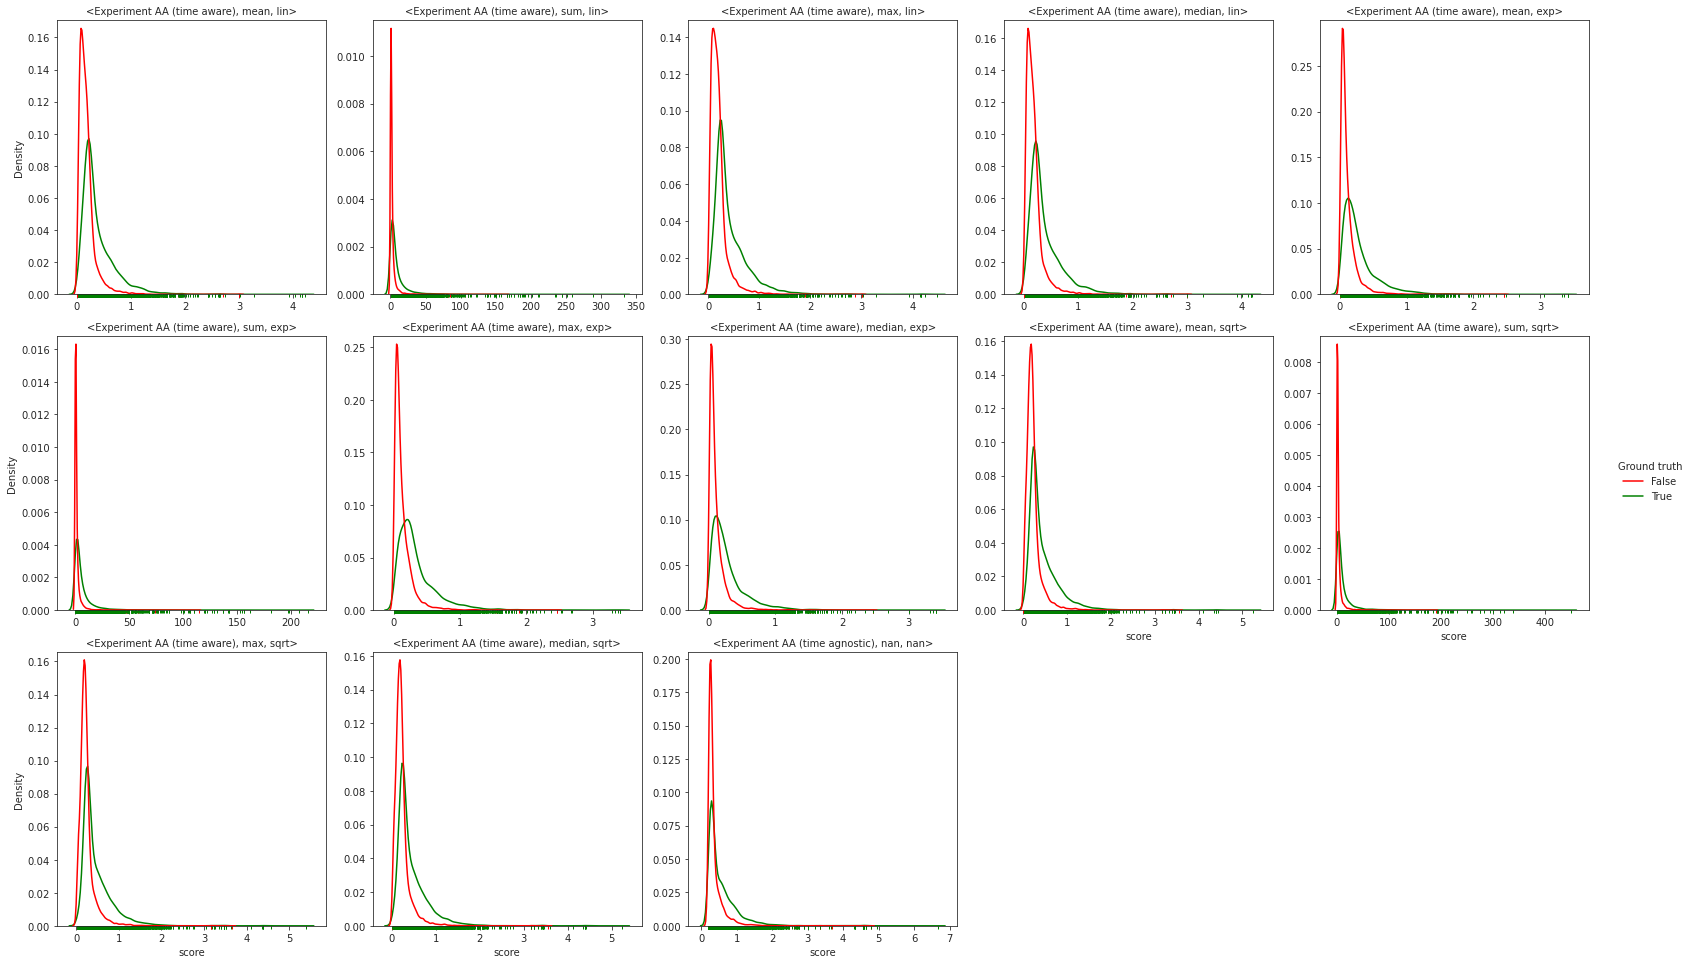

In [187]:
y_sampled = np.load(f'{temp_path}/y_sampled.npy')
g = sns.displot(
  data=pd.DataFrame.from_dict(
    [{'Feature': experiment.__repr__(), 'score': score, 'Ground truth': y}
     for experiment in experiments
     for score, y in zip(experiment.scores, y_sampled)]),
  x='score', hue='Ground truth', col='Feature', kind='kde', 
  palette=['red', 'green'], height=4.5, rug=True, col_wrap=5,
  rug_kws=dict(height=-.01, clip_on=False), 
  facet_kws=dict(sharex=False, sharey=False, despine=False))
g.set_titles(col_template="{col_name}")

## Figure: ROC plot

In [10]:
y_sampled = np.load(f'{temp_path}/y_sampled.npy')
data = pd.DataFrame.from_dict(
    [{'Feature': experiment.__repr__(), 'FPR': fpr, 'TPR': tpr, 
      **experiment.get_parameters()}
     for experiment in experiments
     for fpr, tpr, _ 
     in zip(*sklearn.metrics.roc_curve(y_sampled, experiment.scores))])

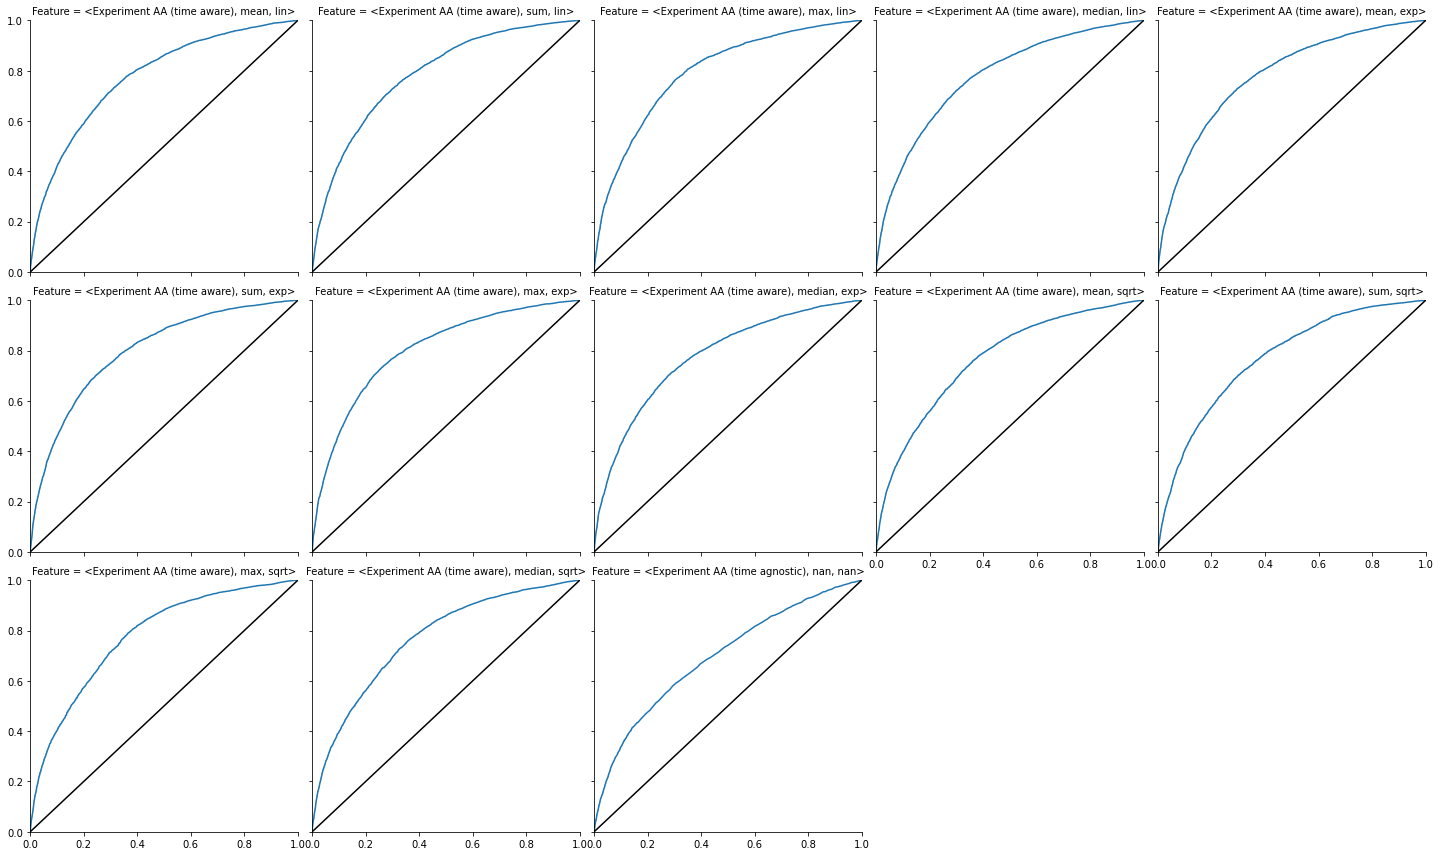

In [12]:
g = sns.relplot(data=data, x='FPR', y='TPR', col='Feature', col_wrap=5, 
                aspect=1, kind='line', height=4)
g.map(plt.axline, xy1=(0,0), xy2=(1,1), c='black')
g.set(xlim=(0,1), ylim=(0,1))

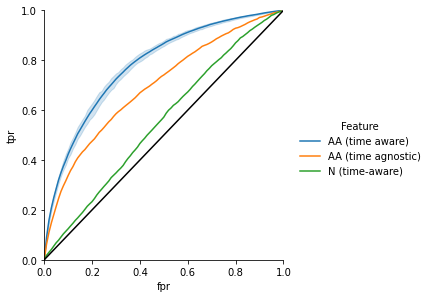

In [71]:
y_sampled = np.load(f'{temp_path}/y_sampled.npy')
data = {tuple(experiment.get_parameters().values()): {
  fpr: tpr
  for fpr, tpr, _ 
  in zip(*sklearn.metrics.roc_curve(y_sampled, experiment.scores))}
 for experiment in experiments}

g = sns.relplot(
  data=(
    pd.DataFrame(data)
    .sort_index()
    .interpolate()
    .reindex(np.arange(0,1,.01), method='nearest')
    .reset_index()
    .melt(id_vars='index', 
          var_name=['Feature', 'Aggregation strategy', 'Time strategy'])), 
  x='index', y='value', hue='Feature', aspect=1, kind='line', height=4, ci=100)
g.map(plt.axline, xy1=(0,0), xy2=(1,1), c='black')
g.set(xlim=(0,1), ylim=(0,1), xlabel='fpr', ylabel='tpr')

## Table: AUC

In [98]:
y_sampled = np.load(f'{temp_path}/y_sampled.npy')
pd.Series(
  {tuple(experiment.get_parameters().values()): 
   sklearn.metrics.roc_auc_score(y_sampled, experiment.scores) 
   for experiment in experiments}
).reset_index().groupby(['level_0']).mean()

/home/bruingjde/.conda/envs/networkdatascience/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').